# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

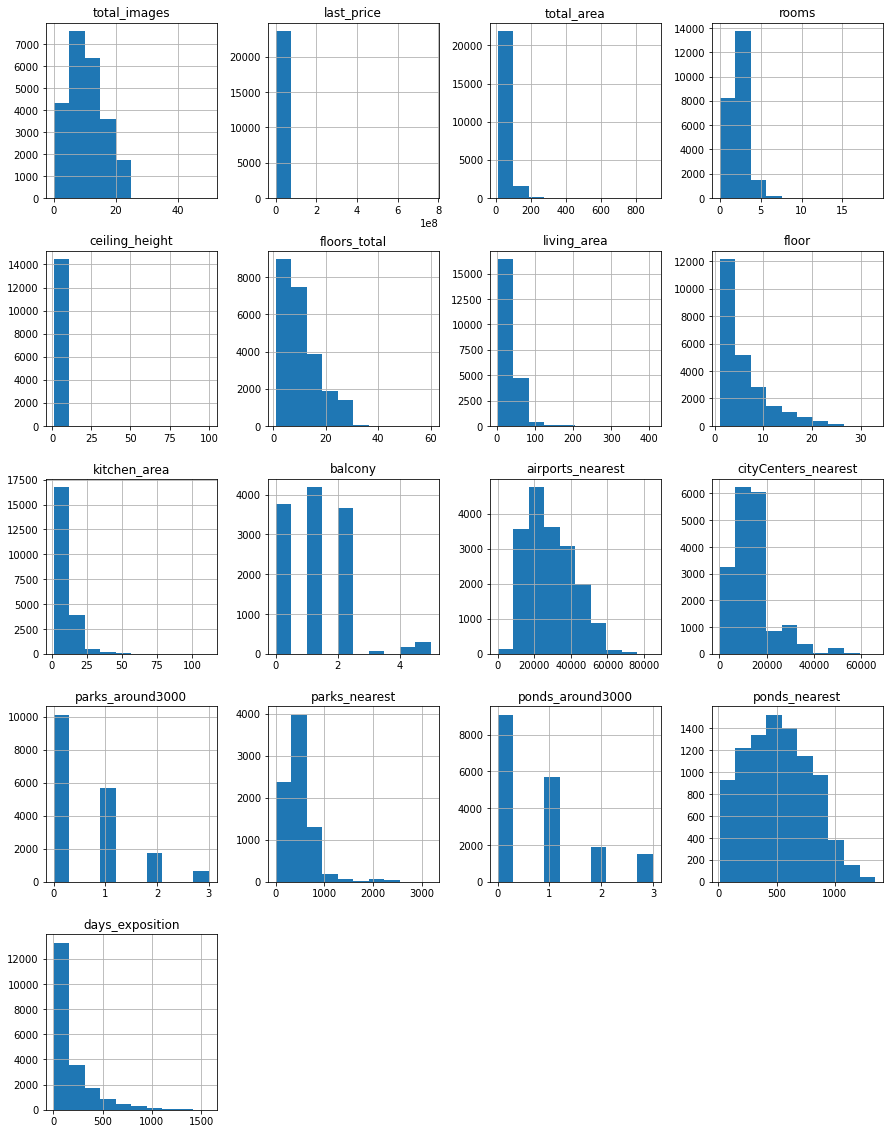

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
df.info()
df.hist(figsize=(15, 20))
pass

In [3]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Предобработка данных

#### Пропущенные значения
Всего в датафрейме 23699 строк. Пропуски есть в 14 столбцах из 22.

|Номер столбца | Название | Кол-во пропущенных значений |
|-:|:-|:-:|
5 | ceiling_height        |  9195 | non-null  float64
6 |  floors_total         |    86 | non-null  float64
7 |  living_area          |  1903 | non-null  float64
9 |  is_apartment         | 20924 | non-null  object 
12 | kitchen_area         |  2278 | non-null  float64
13 |  balcony             | 11519 | non-null  float64
14 | locality_name        |    49 | non-null  object 
15 | airports_nearest     |  5542 | non-null  float64
16 | cityCenters_nearest  |  5519 | non-null  float64
17 | parks_around3000     |  5518 | non-null  float64
18 | parks_nearest        | 15620 | non-null  float64
19 | ponds_around3000     |  5518 | non-null  float64
20 | ponds_nearest        | 14589 | non-null  float64
21 | days_exposition      |  3181 | non-null  float64

##### Причины и заполнение пропущенных значений  

 **is_apartment (9)** - Пропущенные значения скорее всего обозначают, что этот объект НЕ АПАРТАМЕНТЫ.  
 **balcony (13)** - Пропущенные значения скорее всего обозначают, что БАЛКОНА НЕТ.  
 **parks_around3000 (17)  
 ponds_around3000 (19)**  
Пропущенные значения скорее всего обозначают, что ПАРКОВ, ПРУДОВ на расстоянии до 3000 метров НЕТ.  
**Заполняем пропущенные значения в этих 4 столбцах - 0** 
  
 **airports_nearest (15)   
 parks_nearest (18)  
 ponds_nearest (20)**   
Пропущенные значения в этих столбцах скорее всего обозначают, что рядом с объектом нет аэропортов, парков, прудов, расстояние до которых, имеет смысл указывать. Например, ближайший аэропорт находится в другом городе.  
 **cityCenters_nearest (16)**  
Пропущенные значения скорее всего обозначают, что расстояние до центра не имеет смысл указывать. Например, это маленький населенный пункт. Второй возможный вариант - пользователь не указал данные.  
 **ceiling_height (5)  
 floors_total (6)  
 living_area (7)    
 kitchen_area (12)**  
Пропущенные значения скорее всего возникли, потому что пользователь не указал данные.   
**Заполнить пропущенные данные в этих 8 столбцах нечем, оставляем пропущенные значения.**  

**Причина пропущенных значений в этих 12 столбцах, скорее всего в том, что пользователь не заполнил данные.**

**locality_name (14)**  
Пропущенные значения скорее всего возникли, потому что пользователь забыл указать данные или ошибся при вводе данных. Либо произошла ошибка при выгрузке данных из базы. Этот столбец критически значимый для понимания ценности объекта. Восстановить данные в нем невозможно. Строк с пропусками в этом столбце мало (49), их надо удалить.  

**Причина пропущенных значений в этом столбце, ошибка пользователя или ошибка выгрузки данных из базы.**

 **days_exposition (21)**  
Пропущенные значения скорее всего возникли, из-за ошибки базы данных.
Можно заменить медианным значением.

**Причина пропущенных значений в этом столбце, ошибка в базе данных или ошибка выгрузки данных из базы.**

In [4]:
print(f"Количество пропущенных значений до замены:\n{df[['is_apartment', 'balcony', 'parks_around3000', 'ponds_around3000', 'locality_name', 'days_exposition']].isna().sum()}")
df[['is_apartment', 'balcony', 'parks_around3000', 'ponds_around3000']] =\
    df[['is_apartment', 'balcony', 'parks_around3000', 'ponds_around3000']].fillna(0)
df = df.dropna(subset=['locality_name']).reset_index(drop=True)
df['days_exposition'] = df['days_exposition'].fillna(df['days_exposition'].median())
print(f"\nКоличество пропущенных значений после замены:\n{df[['is_apartment', 'balcony', 'parks_around3000', 'ponds_around3000', 'locality_name', 'days_exposition']].isna().sum()}")

Количество пропущенных значений до замены:
is_apartment        20924
balcony             11519
parks_around3000     5518
ponds_around3000     5518
locality_name          49
days_exposition      3181
dtype: int64

Количество пропущенных значений после замены:
is_apartment        0
balcony             0
parks_around3000    0
ponds_around3000    0
locality_name       0
days_exposition     0
dtype: int64


**Вывод:**  
Причины пропусков в **is_apartment, balcony, parks_around3000 ponds_around3000, airports_nearest, parks_nearest, ponds_nearest, ceiling_height, floors_total, living_area, kitchen_area** скорее всего в том, что пользователь не указал данные.  
Причины пропусков в **cityCenters_nearest** скорее всего в том, что расстояние до центра не имеет смысл указывать, это маленький населенный пункт.  
Причины пропусков в **locality_name** скорее всего в том, что  пользователь забыл указать данные.  
Причины пропусков в **days_exposition** скорее всего возникли из-за ошибки в базе данных или ошибке при выгрузке данных из базы.  
Пропущенные значения в столбце **days_exposition** заменены медианой.

#### Типы данных в столбцах

|Номер столбца | Название | Тип |
|-:|:-|:-|
 0 |  total_images        |  int64  
 1 |  last_price          |  float64
 2 |  total_area          |  float64
 3 |  first_day_exposition|  object 
 4 |  rooms               |  it64  
 5 |  ceiling_height      |  float64
 6 |  floors_total        |  float64
 7 |  living_area         |  float64
 8 |  floor               |  int64  
 9 |  is_apartment        |  object 
 10|  studio              |  bool   
 11|  open_plan           |  bool   
 12|  kitchen_area        |  float64
 13|  balcony             |  float64
 14|  locality_name       |  object 
 15|  airports_nearest    |  float64
 16|  cityCenters_nearest |  float64
 17|  parks_around3000    |  float64
 18|  parks_nearest       |  float64
 19|  ponds_around3000    |  float64
 20|  ponds_nearest       |  float64
 21|  days_exposition     |  float64

Cтолбцы 3, 6, 9, 13, 17, 19, 21 имеют не правильный тип данных.  
3 - **first_day_exposition** имеет тип **object**, но содержит дату, преобразовываем к **datetime** типу.  
9 - **is_apartment** имеет тип **object**, но содержит логическое значение, преобразовываем к **bool** типу.      
6 - **floors_total**  
13 - **balcony**  
17 - **parks_around3000**  
19 - **ponds_around3000**  
21 - **days_exposition**  
эти столбцы имеют тип **float64**, но содержат целое значение (кол-во балконов, этажей, парков, прудов, дней), преобразовываем к типу **int64** (**floors_total** к типу **Int64**, что бы преобразовать значения NaN к целому типу)

In [5]:
print(f'Типы столбцов до замены:\n{df.dtypes}')
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y.%m.%d %H:%M:%S')
df['is_apartment'] = df['is_apartment'].astype(bool)
df[['balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']] = df[['balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']].astype('int64')
df['floors_total'] = df['floors_total'].astype('Int64')
print(f'Типы столбцов после замены:\n{df.dtypes}')

Типы столбцов до замены:
total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object
Типы столбцов после замены:
total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 flo

In [6]:
df['last_price'] = df['last_price'].astype('int64')

тип столбца last_price - заменен на int64, т.к. содержит целочисленное значение, ведь никто не продаёт недвижку с копейками. )

**Вывод:**  
Заменен тип данных у 7 столбцов.  
тип столбца first_day_exposition - заменен на datetime, т.к. содержит дату.  
тип столбца is_apartment - заменен на bool, т.к. содержит логическое значение.  
типы столбцов floors_total, balcony, parks_around3000, ponds_around3000, days_exposition - заменен на int64, т.к. содержат целочисленные значения.

#### Устранение дубликатов. 

Столбец **locality_name** содержит неявные дубликаты. Часто встречается слово "посёлок", записанное как "поселок".  
Поменяем 'поселок' на 'посёлок'.

In [7]:
print('Количество уникальных значений до замены: ', df['locality_name'].nunique())
df['locality_name'] = df['locality_name'].str.replace('поселок.', 'посёлок ', regex=True)
print('Количество уникальных значений после замены: ', df['locality_name'].nunique())

Количество уникальных значений до замены:  364
Количество уникальных значений после замены:  330


Изучение названий населенных пунктов позволяет предположить, что следующие записи являются неявными дубликатами:

 ['посёлок Мурино', 'Мурино'],  
 ['деревня Кудрово', 'Кудрово'],  
 ['городской посёлок Рощино', 'посёлок городского типа Рощино'],  
 ['городской посёлок Советский', 'посёлок городского типа Советский'],  
 ['городской посёлок Большая Ижора', 'посёлок городского типа Большая Ижора'],  
 ['городской посёлок Павлово', 'посёлок городского типа Павлово'],  
 ['городской посёлок Лесогорский', 'посёлок городского типа Лесогорский'],  
 ['городской посёлок Мга', 'посёлок городского типа Мга'],  
 ['городской посёлок Назия', 'посёлок городского типа Назия'],  
 ['посёлок Рябово', 'посёлок городского типа Рябово'],  
 ['посёлок станции Вещево', 'посёлок при железнодорожной станции Вещево'],  
 ['посёлок станции Приветнинское', 'посёлок при железнодорожной станции Приветнинское']  
 
Сделаем замену.  

In [8]:
rep = {
    'Мурино':'посёлок Мурино',  
    'Кудрово':'деревня Кудрово',  
    'городской посёлок Рощино':'посёлок городского типа Рощино',  
    'городской посёлок Советский':'посёлок городского типа Советский',  
    'городской посёлок Большая Ижора':'посёлок городского типа Большая Ижора',  
    'городской посёлок Павлово':'посёлок городского типа Павлово',  
    'городской посёлок Лесогорский':'посёлок городского типа Лесогорский',  
    'городской посёлок Мга':'посёлок городского типа Мга',  
    'городской посёлок Назия':'посёлок городского типа Назия',  
    'посёлок Рябово':'посёлок городского типа Рябово',  
    'посёлок станции Вещево':'посёлок при железнодорожной станции Вещево',  
    'посёлок станции Приветнинское':'посёлок при железнодорожной станции Приветнинское'    
}

print('Количество уникальных значений до замены: ', df['locality_name'].nunique())
df['locality_name'] = df['locality_name'].replace(rep)
print('Количество уникальных значений после замены: ', df['locality_name'].nunique())

Количество уникальных значений до замены:  330
Количество уникальных значений после замены:  318


**Вывод:**  
Выявлены и исправлены неявные дубликаты в названиях населенных пунктов. Исправлено 46 неявных дубликатов.   
Удалены строки с пропусками в названии населенного пункта.

#### Редкие и выбивающиеся значения. 



Проверим выбивающиеся значения в столбце **ceiling_height**.

In [9]:
df.query('ceiling_height > 8.5 or ceiling_height < 2')['ceiling_height'].value_counts()

27.00     8
25.00     7
32.00     2
14.00     1
1.75      1
24.00     1
27.50     1
20.00     1
100.00    1
10.30     1
22.60     1
26.00     1
1.20      1
1.00      1
Name: ceiling_height, dtype: int64

Значения больше 19 метров (т.к. потолки ниже 1.9 метра вряд ли где-то встречаются) уменьшим в 10 раз. Скорее всего это ошибки ввода. Из всех значений, значения меньше 2 и больше 8,5 метров, поменяем на NaN. Такие строки удалять не будем, т.к. остальные данные в них выглядят правдоподобно.

In [10]:
def heigth_2_8(): # возвращает кол-во строк с высотой потолков до 2 и свыше 8,5 метров
    return df.query('ceiling_height > 8.5 or ceiling_height < 2')['ceiling_height'].count()

print(f"Значений в промежутке 2 < ceiling_height < 8.5 до замены : {heigth_2_8()}")
df.loc[df['ceiling_height'] > 19, 'ceiling_height'] = df.loc[df['ceiling_height'] > 19, 'ceiling_height'] / 10
df.loc[((df['ceiling_height'] > 8.5) | (df['ceiling_height'] < 2)), 'ceiling_height'] = np.nan
print(f"Значений в промежутке 2 < ceiling_height < 8.5 после замены : {heigth_2_8()}")

Значений в промежутке 2 < ceiling_height < 8.5 до замены : 28
Значений в промежутке 2 < ceiling_height < 8.5 после замены : 0


Проверим значения столбца **floors_total**. Зданий выше 42 этажей в Санкт-Петербурге и Ленинградской области нет.

In [11]:
df.query('floors_total > 42')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2251,12,3800000,45.5,2018-06-28,2,2.88,60,27.4,4,False,False,False,7.4,0,Кронштадт,67763.0,49488.0,2,342.0,3,614.0,166
16701,9,3978000,40.0,2018-09-24,1,2.65,52,10.5,18,False,False,False,14.0,0,Санкт-Петербург,20728.0,12978.0,1,793.0,0,NaN,45


Значение 60 скорее всего ошибка ввода, можно исправить на 6.  
Значение 52 не понятно на что исправлять, удалим сту строку.

In [12]:
df.loc[df.floors_total == 60, 'floors_total'] = 6
df = df[df.floors_total != 52].reset_index(drop=True)
print(f"Количество записей с 'floors_total' > 42 : {df.query('floors_total > 42')['floors_total'].count()}")

Количество записей с 'floors_total' > 42 : 0


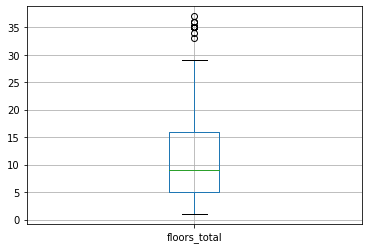

In [13]:
df.boxplot(column=['floors_total'])
pass

Значения 60 и 52 уже исправлены, остальные выбросы, являются корректными данными. Все остальные столбцы в вызросах заполнены правдоподобно. Столбцы общая этажность, расстояние до аэропорта и цента города почти во всех строках имеют одинаковые значения. Очевидно все эти квартиры находятся в одном высотном ЖК. 

Посмотрим минимальное и максимальное значения в каждом столбце

In [14]:
df.agg(['min', 'max'])

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
min,0,12190,12.0,2014-11-27,0,2.0,1,2.0,1,False,False,False,1.3,0,Бокситогорск,0.0,181.0,0,1.0,0,13.0,1
max,50,763000000,900.0,2019-05-03,19,8.3,37,409.7,33,True,True,True,112.0,5,село Шум,84869.0,65968.0,3,3190.0,3,1344.0,1580


Неправдоподобно выглядит минимальная цена объекта 12190. Рассмотрим подробнее

In [15]:
df.loc[df.last_price == 12190]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8750,7,12190,109.0,2019-03-20,2,2.75,25,32.0,25,False,False,False,40.5,0,Санкт-Петербург,36421.0,9176.0,1,805.0,0,NaN,8


Объект площадью 109 м2 в Санкт-Петербурге не может стоить 12190, это ошибка. Оценим среднюю и медиану стоимости таких объектов в этом городе.

In [16]:
df.loc[(df.total_area == 109) & (df.locality_name == 'Санкт-Петербург'), 'last_price'].\
        agg(['mean', 'median', 'count']).astype('int64')

mean      15074008
median    13350000
count           22
Name: last_price, dtype: int64

Медиана 13,4 млн, среднее 15 млн. Количестов объектов 22. Судя по полученным данным цена 12190, это цена указанная в тыс. Заменим 12'190 на 12'190'000

In [17]:
df.loc[df.last_price == 12190, 'last_price'] = 12190000
df.loc[8750, 'last_price']

12190000

Непонятно выглядит значение 0 в столбце **airports_nearest**, либо ошибка, либо объект находится прямо в аэропорту.  
Посмотрим сколько объектов находится ближе 6 км к аэропорту.

In [18]:
df[df.airports_nearest < 6000]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20967,0,7000000,34.7,2018-09-23,1,2.7,9,19.8,3,False,False,False,6.0,2,Санкт-Петербург,0.0,22801.0,0,NaN,0,NaN,60


Значений меньше 6000 в столбце **airports_nearest** больше нет, скорее всего это ошибка, заменим 0 на Nan 

In [19]:
df.loc[df.airports_nearest == 0, 'airports_nearest'] = np.nan

Проверим нет ли в данных строк, в которых общее количество этажей, меньше этажа объекта.

In [20]:
df.query('floors_total < floor')['floors_total'].count()

0

Количество таких строк 0. Данные этажей корректны.

Проверим нет ли в данных, в которых общая площадь меньше суммы жилой площади и кухни.

In [21]:
df.query('total_area < (living_area + kitchen_area)')['total_area'].count()

64

Есть 64 строки в которых очевидно какая-то из площадей указана не правильно. Остальные данные в этих строках выглядят правдоподобно, поэтому заменим значения в столбце **kitchen_area** (как наименее значимый) на nan. Менять будем там где разница более 3 метров (произвольный выбор), что бы не терять данные при незначительной ошибке.

In [22]:
df.loc[(df.total_area - df.living_area - df.kitchen_area) < -3, 'kitchen_area'] = np.nan
print('Количество объектов, где общая площадь меньше суммы жилой площади и кухни больше чем на 3 метра:')
df.query('(total_area - living_area - kitchen_area) < -3')['total_area'].count()

Количество объектов, где общая площадь меньше суммы жилой площади и кухни больше чем на 3 метра:


0

In [23]:
print(f"Явных полных дубликатов: {df.duplicated().sum()}")

Явных полных дубликатов: 0


**Вывод:**  
В столбце высота потолка значения больше 19 метров умнеьшили в 10 раз. Считаю это ошибками ввода, когда, например, вместо 2,5 метров указывают 25 метров.  
Удалены строки с высотой потолков менее 2 и более 8,5 метров.  
Исправлена строка с 60 этажем объекта, значениезаменено на 6. (в Питере и области самый высокий жилой дом 42 этажа.)  
Удалена строка с 52 этажем объекта.  
Исправлена цена объекта, 12'190 заменено на 12'190'000, т.к. в этом городе у объектов этой площади медианная цена 13,4 млн.  
Исправлена строка с расстоянием до аэропорта 0 метров, значение заменено на NaN.  
Найдены 64 строки, в которых общая площадь, меньше суммы жилой площади и кухни. Остальные данные выглядят правдоподобно, поэтому что бы не терять данные, там где разница более 3 м2, площадь кухни заменена на NaN.  
Проверено что бы этаж объекта не превосходил этажность здания.

Проверено на отсутствие явных дубликатов записей.

### Посчитайте и добавьте в таблицу новые столбцы

#### Добавим в таблицу столбец с ценой одного квадратного метра

In [24]:
df['price_m2'] = round(df['last_price'] / df['total_area'], 2)

#### Добавим в таблицу столбец с днем недели публикации объявления

In [25]:
df['publ_day_week'] = df['first_day_exposition'].dt.weekday

#### Добавим в таблицу столбец с месяцем публикации объявления

In [26]:
df['publ_month'] = pd.DatetimeIndex(df['first_day_exposition']).month

#### Добавим в таблицу столбец с год публикации объявления

In [27]:
df['publ_year'] = pd.DatetimeIndex(df['first_day_exposition']).year

#### Добавим в таблицу столбец с типом этажа квартиры

In [28]:
def set_floor_type(row):
    s = 'другой'
    if row['floors_total'] == row['floor']: s = 'последний'
    if row['floor'] == 1: s = 'первый'
    return s    
    
df['floor_type'] = df.apply(set_floor_type, axis=1)

#### Добавим в таблицу столбец с расстоянием до центра города в километрах

In [29]:
df['cityCenters_nearest_km'] = round(df['cityCenters_nearest'] / 1000, 0)

### Исследовательский анализ данных

#### Параметры объектов.

На общей гистограмме видно, что основная масса объектов имеет общую площадь до 200 м2. Оценим детальнее.

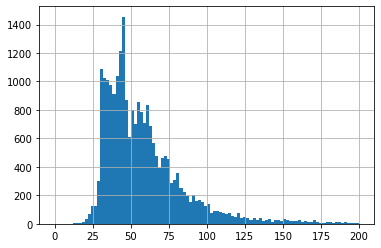

In [30]:
df['total_area'].hist(bins=100, range=(0, 200))
pass

Больше всего объектов имеет площадь от 30 до 80 м2. Больше всего квартир с площадью 45 м2, есть выраженный провал в площади ровно 50 м2. Возможно 50 м2 для однокомнатной квартиры слишком много, а для двухкомнатной слишком мало, поэтому такая площадь встречается редко.

На общей гистограмме видно, что основная масса объектов имеет жилую площадь до 120 м2. Оценим детальнее.

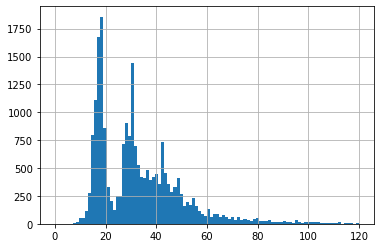

In [31]:
df['living_area'].hist(bins=100, range=(0, 120))
pass

На гистограмме видно 3 больших пика примерно на значениях 18, 30 и 42 м2. Очевидно что это 1, 2 и 3 комнатные квартиры. Провалы между пиками показывают, что квартир с очень большими или очень маленькими комнатами значительно меньше.

На общей гистограмме видно, что основная масса объектов имеет кухню площадью до 25 м2. Оценим детальнее.

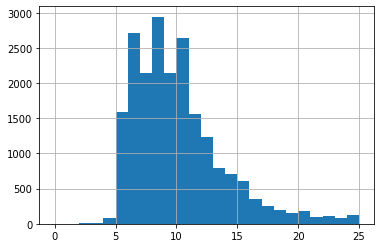

In [32]:
df['kitchen_area'].hist(bins=25, range=(0, 25))
pass

В основном кухни имеют площадь от 6 до 12 м2, наиболеечасто встречаются 7, 9 или 11 м2.

На общей гистограмме видно, что данные в столбце цена объекта имеют сильный выброс. Оценим детальнее

In [33]:
df['last_price'].sort_values().tail(15)

1022     155000000
16406    159000000
2527     159984000
19047    160000000
19755    180000000
8857     190870000
5863     230000000
13671    240000000
16372    245000000
22700    289238400
15565    300000000
1431     330000000
14621    401300000
19430    420000000
12897    763000000
Name: last_price, dtype: int64

Из всех объектов только 15 имеют цену больше 155 млн.

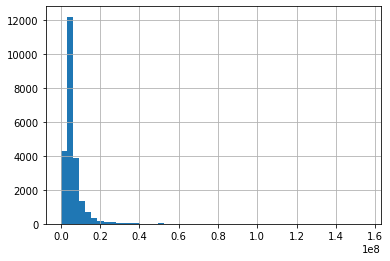

In [34]:
df['last_price'].hist(bins=50, range=(0,155000000))
pass

Основная масса объектов стоит до 20 млн. 

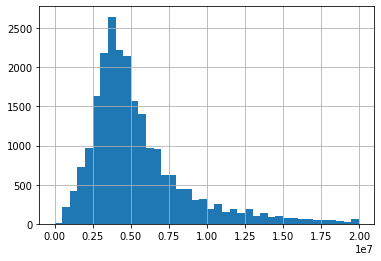

In [35]:
df['last_price'].hist(bins=40, range=(0,20000000))
pass

На гистограмме ничего не обычного не видно. Самая распространненая цена объекта 4 млн.

На общей гистограмме видно, что данные в столбце количество комнат имеют сильный выброс и больше 6 комнат встречается редко.  
Оценим детальнее

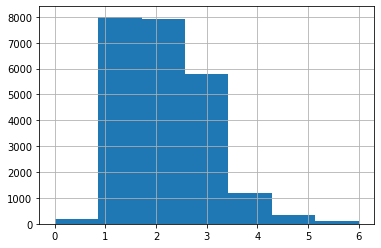

In [36]:
df['rooms'].hist(bins=7, range=(0, 6))
pass

Основная масса - это 1,2 и 3 комнатные квартиры. 1 и 2 комнатных квартир почти одинаковое количество. Объектов с количеством комнат больше 5 очень мало, больше 7 комнат - единичные объекты.

На общей гистограмме видно, что данные в столбце высота потолков имеют сильный выброс и основная масса объектом имеет потолки высотой до 10 м. Оценим детальнее.

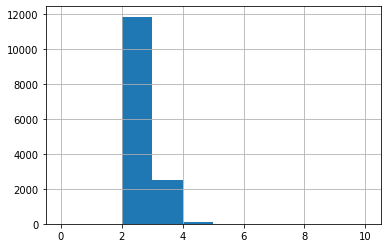

In [37]:
df['ceiling_height'].hist(bins=10, range=(0, 10))
pass

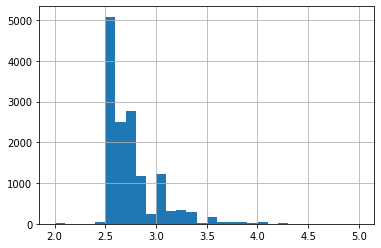

In [38]:
df['ceiling_height'].hist(bins=30, range=(2, 5))
pass

В основном потолки высотой 2.5-2,7 м, есть отдельный большой класс объектов с высотой потолков 3 м.

На общей гистограмме видно, что данные в столбце этаж объекта правдоподобны. Выбросов нет. Основная масса объектов расположены до 16 этажа.

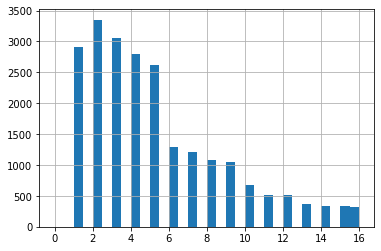

In [39]:
df['floor'].hist(bins=32, range=(0, 16))
pass

На гистограмме видны ярко выраженные категории. Объекты находящиеся с 1 по 5 этаж и с 6 по 9 этаж. Очевидно это связано с тем, что дома, в которых находятся квартиры, 5 и 9 этажные. Больше всего квартир продается на 2 этаже.

Гистограмма типа этажа.

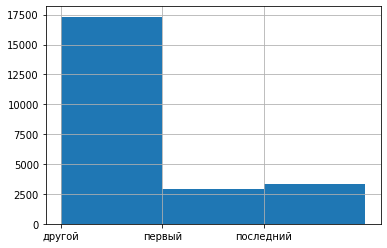

In [40]:
df['floor_type'].hist(bins=3, range=(0, 3))
pass

На продажу выставляют приерно одинаково квартир на последних этажах и на первых этажах.

На общей гистограмме видно, что данные в столбце всего этажей имеют сильный выброс. Почти все объекты имеют высоту до 30 этажей. Оценим детальнее

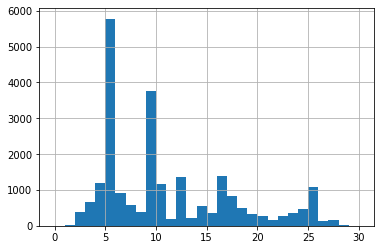

In [41]:
df['floors_total'].hist(bins=30, range=(0, 30))
pass

По данным гистограммы, основная масса домов, это 5, 9, 10, 12, 16, 24 этажные. Что соответствует типовой застройке по стране.

На общей гистограмме видно, что основная масса объектов находится на растоянии до 40 км от центра (из тех объектов, в данных которых, это расстояние указано).

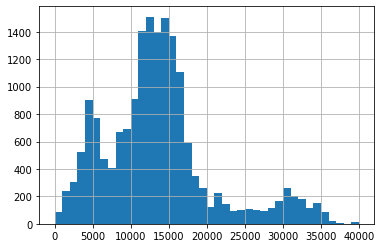

In [42]:
df['cityCenters_nearest'].hist(bins=40, range=(0, 40000))
pass

На гистограмме видны пики на значениях 4-5 км от центра, и 11-15 км от центра. Возможно это исторический центр и новые районы.

На общей гистограмме видно, что основная масса объектов находится на растоянии от 5 до 60 км от аэропорта.

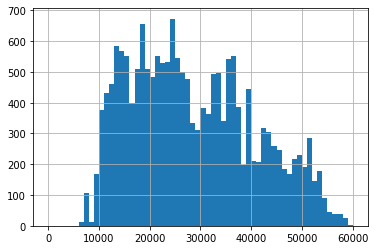

In [43]:
df['airports_nearest'].hist(bins=60, range=(0, 60000))
pass

На гистограмме видны пики (и выраженные провалы) на разных расстояниях от аэропорта. Очевидно, что это разные населенные пункты (или возможно разные большие районы одного города). Ближайший значительный населенный пункт находится на расстоянии 7 км от аэропорта. На расстоянии 13-15 км очевидно находится центр Санкт-Петербурга.

На общей гистограмме видно, что там где рядом есть парки, основная масса их находится в пределах 1 км.

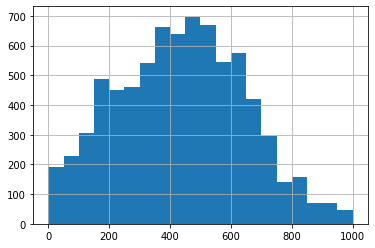

In [44]:
df['parks_nearest'].hist(bins=20, range=(0, 1000))
pass

Гисторгамма выглядит достоверно. Основная масса объектов находящаяся рядом с парками, находится на расстоянии 400-550 м от них.

Гистограмма дня недели подачи объявления.

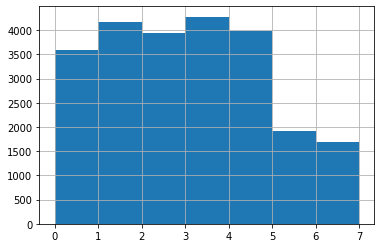

In [45]:
df['publ_day_week'].hist(bins=7, range=(0, 7))
pass

Из гистограммы видно, что объявления в основном размещают по будним дням, примерно одинаково, чуть меньше в понедельник.

Гистограмма месяца подачи объявления.

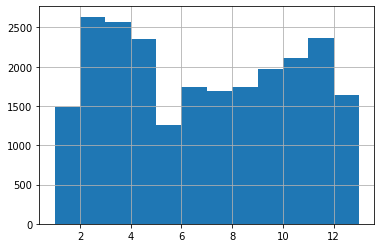

In [46]:
df['publ_month'].hist(bins=12, range=(1, 13))
pass

Из гистограммы видно, что больше всего объявлений подают в феврале-апреле и ноябре, и меньше всего в декабре, январе и мае (скорее всего из-за нового года, майских праздников и начала лета). 

**Вывод:**  
Общая площадь большинства объектов от 30 до 80 м2, есть объекты площадью до 200 м2, больше 200 м2 встречаются редко.  
Жилая площадь объектов имеет выраженные пика на 18, 30 и 42 м2. Очевидно это 1,2 и 3 комнатные квартиры типовой застройки.  
Площадь кухни в основном от 6 до 12 м2, наиболее часто встречаются 7, 9 или 11 м2.  
Основная масса объектов стоит до 20 мнл. Наиболее часто встречаемая цена - 4 млн.  
Большинство объектов - это 1, 2 и 3 комнатные квартиры. 1 и 2 комнатных квартир почти поровну. Объектов с количеством комнат больше 5 очень мало, больше 7 комнат - единичные объекты.  
Высота потолков с основном 2,5-2,7 м, есть много объектов с высотой потолка 3 м.  
Объектов расположенных выше 16 этажа мало. Явно выражены категории домов 5, 9, 10, 12, 16, 24 этажные.  
В расположении домов видны 2 пика, 4 и 13 км от центра города. Возможно это исторический центр и новые районы.  
Объекты расположенные рядом с парками, находятся в основном на расстоянии 0,5 км от них.  
Размещение объявлений происходит в основном со вторника по пятницу.  
Больше всего размещают объектов в феврале-апреле и ноябре, меньше всего в декабре, январе и мае.

#### Скорость продажи квартир.

Гистограмма времени продажи квартир.

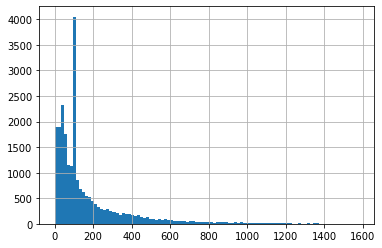

In [47]:
df['days_exposition'].hist(bins=100, range=(0, 1581))
pass

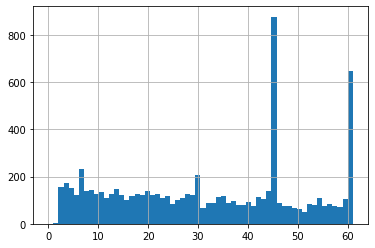

In [48]:
df['days_exposition'].hist(bins=60, range=(0, 61))
pass

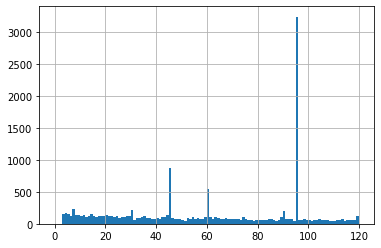

In [49]:
df['days_exposition'].hist(bins=120, range=(0, 120))
pass

In [50]:
df['days_exposition'].describe()

count    23564.000000
mean       169.208963
std        206.500525
min          1.000000
25%         45.000000
50%         95.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64

**Вывод:**  
В целом квартиры лучше всего продаются в начале публикации, со временем скорость продажи квартир уменьшается. На гистограмме виден ярко выраженный пик продаж на 95 день, но это были пропущенные значения, которые заполнены медианой.  
Лучше всего квартиры продаются начиная с 3 до 7 дня после публикации, потом есть пики продаж на 14, 21, 30, **45**, **60** и 90 дни.  
Среднее время продажи квартиры 169 дней, медианное значение 95 дней.  
**Четверть квартир продается за полтора месяца, половина за 3 месяца, три четверти за полгода.** 

Можно считать, что:
- моментальная продажа - это продажа в течении недели  
- быстра продажа - это продажа в течении 1,5 месяцев
- обычная продажа - это продажа в течении полугода
- медленная продажа - это продажа дольше полугода
- необычно долгая продажа - это продажа дольше года

#### Факторы больше всего влияющие на общую (полную) стоимость объекта?

Посмотрим минимальные и максимальные значения полной стоимости объектов.

In [51]:
df.sort_values('last_price')['last_price'].head(200)

17358    430000
14825    430000
16185    440000
17576    450000
9535     450000
          ...  
20198    950000
11935    950000
5471     950000
21544    950000
12893    950000
Name: last_price, Length: 200, dtype: int64

Минимальное значение 430 тыс, за 200 значений (0,8% от общего числа) минимальная цена увеличилась до 950 тыс. В 2,2 раза. Для построения графиков будем использовать все значения снизу.

In [52]:
df.sort_values('last_price')['last_price'].tail(200)

4091      39900000
11315     39900000
8281      39900000
4604      39900000
261       39900000
           ...    
15565    300000000
1431     330000000
14621    401300000
19430    420000000
12897    763000000
Name: last_price, Length: 200, dtype: int64

Максимальное значение 763 млн, за 200 значений (0,8% от общего числа) максимальная цена уменьшилась до 40 млн. В 19 раз. Для корректного построения графиков надо исключить выбросы цены. Отфильтруем все цены выше 40 млн.

In [53]:
df_norm = df.query('last_price < 40000000')

##### Зависимость общей цены от общей площади.

Для построения графиков округлим значения площадей, что бы получить меньше точек и сделать график более читаемым. Для получения тенденции изменений этого будет достаточно.  
Посчитаем медиану общей цены для нивелирования возможных выбросов данных и учтем только те значения, где есть  достаточное количество данных. (определяется аргументом n функции corr_last_price)

In [54]:
def corr_last_price(s, n=0):
#   аргументы s - название столбца df по которому надо преверить зависимость от 'last_price'
#             n - отфильтровать одинаковые значения, которых меньше n
#   возвращаемое значение - сводная таблица индекс s и медиана значений столбца 'last_price'
#
    result = df_norm.copy()
    result[s] = result[s].round()
    result = result.pivot_table(index=s, values='last_price', aggfunc=(['count', 'median']))
    result.columns=['count', 'median']
    result = result.query('count > @n')['median']
    return result

График зависимости общей цены от общей площади. Учитываем только те объекты, которых больше 5.


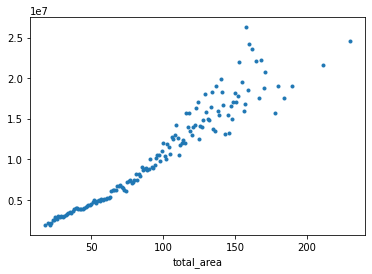

In [59]:
corr_last_price('total_area', 5).plot(linestyle='none', marker='.')
print('График зависимости общей цены от общей площади. Учитываем только те объекты, которых больше 5.')

In [55]:
def corr_scatter(s):
    result = df_norm.pivot_table(index=df_norm[s], values=[s, 'last_price'], aggfunc=(['median']))
    result.columns=['median', s]
    result.plot(x=s, y='median', kind='scatter')
    return result

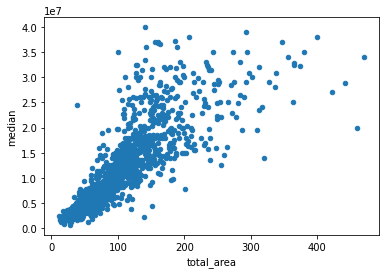

In [56]:
corr_scatter('total_area')
pass

Диаграммы показывает однозначную зависимость цены объета от общей площади. В целом зависимость пропорциональная, хотя встречаются объекты и очень дорогие и достаточно дешевые объекты.

In [57]:
df[['last_price', 'total_area']].corr()

,last_price,total_area
last_price,1.000000,0.653687
total_area,0.653687,1.000000


Корреляция Пирсона между last_price и total_area равна 0,65, что показывает однозначную, достаточно сильную, положительную зависимость.

График зависимости общей цены от общей площади. Учитываем только те объекты, которых больше 100.


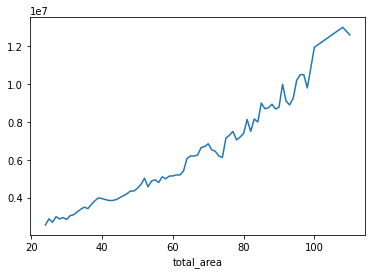

In [58]:
corr_last_price('total_area', 50).plot()
print('График зависимости общей цены от общей площади. Учитываем только те объекты, которых больше 100.')

    На графике учитывающим от 5 объектов одинаковой площади, видна тенденция увеличения общей стоимости объекта при увеличении общей площади. При этом на графике видны пики и провалы, показывающие что есть некоторое количество объектов, которые при большой площади стоят недорого и наоборот при маленькой площади стоят дорого, относительно основной массы объектов.    
    При увеличении количества учитываемых объектов одинаковой площади от 100, график сглаживается показывая что при большом количестве объектов особых пиков или провалов медианной цены нет. Только в районе объектов с площадью 75 м2 наблюдается снижение медианной цены, означающей что есть значительное количество относительно дешевых объектов.   
    Также на графике (n>100) видно что на представленных данных цена в зависимости от площади растет экспоненциально.

##### Зависимость общей цены от жилой площади.

График зависимости общей цены от жилой площади. n > 5


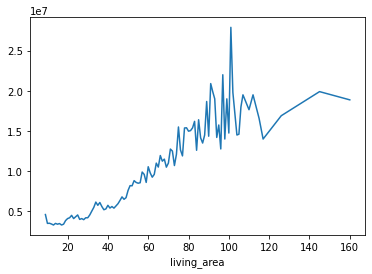

In [59]:
corr_last_price('living_area', 5).plot()
print('График зависимости общей цены от жилой площади. n > 5')

График зависимости общей цены от жилой площади. n > 40


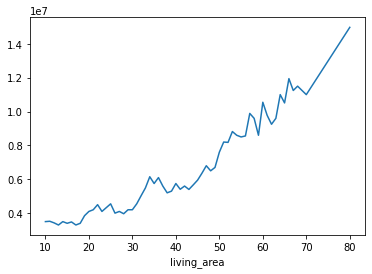

In [60]:
corr_last_price('living_area', 40).plot()
print('График зависимости общей цены от жилой площади. n > 40')

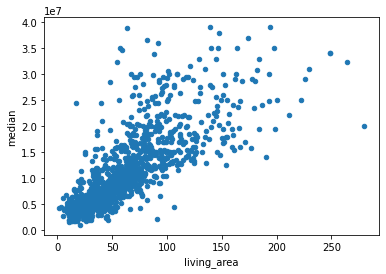

In [61]:
corr_scatter('living_area')
pass

Зависимость цены от жилой площади более "размазанная", но такая же очевидная, как от общей площади.

In [62]:
df[['last_price', 'living_area']].corr()

,last_price,living_area
last_price,1.000000,0.566379
living_area,0.566379,1.000000


Корреляция Пирсона показывает зависимость цены от жилой площади, но эта зависимость выражена слабее, чем зависимость от общей площади.

На графиках зависимости цены от жилой площади видна примерно такая же картина, как на графиках зависимости цены от общей площади. При рассмотрении от 5 объектов одинаковой площади, видна тенденция увеличения цены при увеличении жилой площади. Наблюдаются пики и провалы графика, соответствующие дорогим и дешевым объектам. Сильный пик около 100 м2 соответствующий очень дорогим объектам.  
При рассотрении от 40 объектов одинаковой площади медианная цена сглаживается, и показывает общую экспоненциальную зависимость роста стоимости объектов от роста жилой площади.

##### Зависимость общей цены от площади кухни.

График зависимости общей цены от площади кухни. n > 2


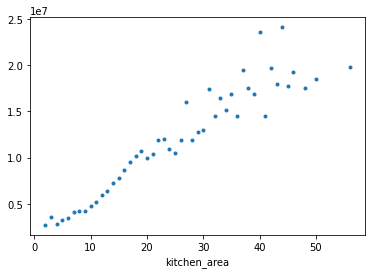

In [63]:
corr_last_price('kitchen_area', 2).plot(style='.')
print('График зависимости общей цены от площади кухни. n > 2')

График зависимости общей цены от площади кухни. n > 20


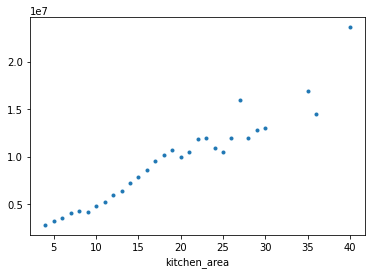

In [64]:
corr_last_price('kitchen_area', 20).plot(style='.')
print('График зависимости общей цены от площади кухни. n > 20')

,median,kitchen_area
kitchen_area,,
1.30,1.30,4250000.0
2.00,2.00,2720000.0
2.30,2.30,2940000.0
2.40,2.40,2200000.0
2.89,2.89,5967734.0
...,...,...
62.50,62.50,25900000.0
64.00,64.00,10495000.0
65.00,65.00,23150000.0


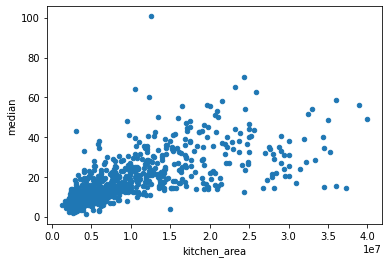

In [65]:
corr_scatter('kitchen_area')

Зависимость цены от площади кухни есть, но не такая ярко выраженная.

In [66]:
df[['last_price', 'kitchen_area']].corr()

,last_price,kitchen_area
last_price,1.000000,0.522023
kitchen_area,0.522023,1.000000


Корреляция Пирсона показывает зависимость цены от площади кухни, но эта зависимость выражена еще слабее, чем зависимость от общей площади.

Графики зависимости стоимости объектов от площади кухни в целом показывают, что при увеличении площади кухни, стоимость объектов возрастает, но скорее всего это связано с тем, что площадь кухни увеличивается при увеличении общей и жилой площади объекта. 

##### Зависимость общей цены от количества комнат.

График зависимости общей цены от количества комнат. n > 2


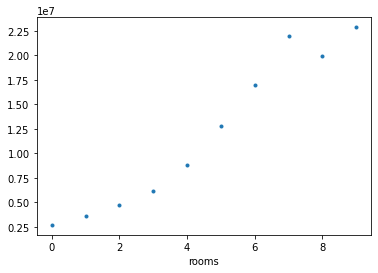

In [67]:
corr_last_price('rooms', 2).plot(style='.')
print('График зависимости общей цены от количества комнат. n > 2')

График зависимости общей цены от количества комнат. n > 10


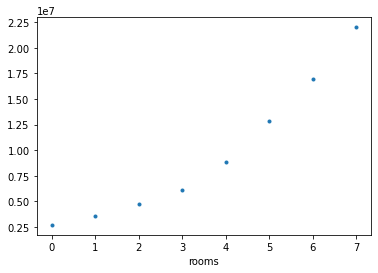

In [68]:
corr_last_price('rooms', 10).plot(style='.')
print('График зависимости общей цены от количества комнат. n > 10')

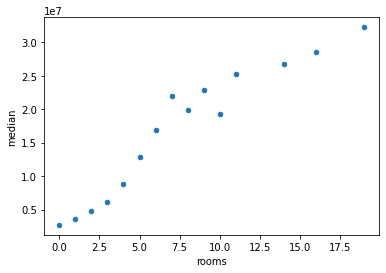

In [69]:
corr_scatter('rooms')
pass

Диаграмма показывает резкий рос стоимости объектов в промежутке от 4 до 7 комнат. Возможно это связанно с тем, что с 4 комнат начинается жилье повышенного класса и большей площади. Скорость роста замедляется после 7 комнат, потому что в основной массе квартиры имеют до 8 комнат, свыше уже сильно не типичное жилье, спрос на которое не такой сильный. 

In [70]:
df[['last_price', 'rooms']].corr()

,last_price,rooms
last_price,1.000000,0.363186
rooms,0.363186,1.000000


Корреляция Пирсона показывает что зависимость цены от количества комнат есть, но еще более слабая, чем от площади кухни.

Графики зависимости стоимости объектов от количества комнат, показывают что при увеличении количества комнат стоимость объекта растет. При этом от 1 до 3 комнат стоимость растет пропорционально, начиная с 4 комнат стоимость начинает рости быстрее. Возможно объекты с количеством комнат более 3, в основной массе перестают относиться к бюджетному жилью.

##### Зависимость общей цены от типа этажа объекта.

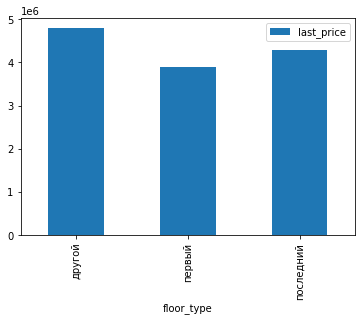

In [71]:
df_norm.pivot_table(index='floor_type', values='last_price', aggfunc=('median')).plot(kind='bar')
pass

Графики зависимости стоимости объектов от типа этажа показывает, что стоимость от типа этажа хотя зависит, но не сильно. В целом самые дешевые объекты на первом этаже, потом на последнем, потом другие.

##### Зависимость общей цены от даты размещения объекта

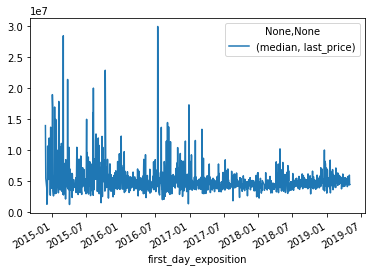

In [72]:
df_norm.pivot_table(index='first_day_exposition', values='last_price', aggfunc=(['median'])).plot()
pass

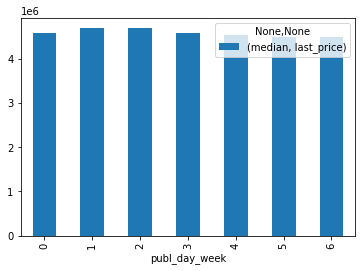

In [73]:
df_norm.pivot_table(index='publ_day_week', values='last_price', aggfunc=(['median'])).plot(kind='bar')
pass

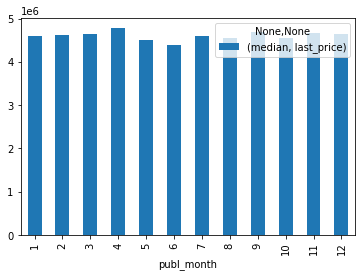

In [74]:
df_norm.pivot_table(index='publ_month', values='last_price', aggfunc=(['median'])).plot(kind='bar')
pass

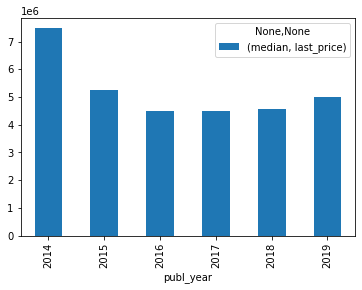

In [75]:
df_norm.pivot_table(index='publ_year', values='last_price', aggfunc=(['median'])).plot(kind='bar')
pass

Гистограммы зависимостей цены объектов от даты размещения показывают, что цена практически не зависит ни от дня, ни от месяца размещения. Относительно годов размещения можно сказать, что в 2014, 2015 году размещались более дорогие объекты, потом был спад и в 2016,2017 и2018 годах цены бали одинаковые, в 2019 пошел небольшой рост цен.

Графики зависимости стоимости объектов от даты размещения объектов показывает, что в целом стоимость от даты размещения не зависит. Медианная цена объектов медленно растет с 2015 до 2019 годы. В 2015 г стоимость была 4 млн, в 2019 г уже скорее 5млн. Также на графике видно что с 2015 по 2017 годы появлялись очень дорогие объекты, таких в 2019 уже не было. 

**Вывод:**
Стоимость квартир сильно зависит от общей площади. Жилая площадь, площадь кухни, количество комнат в целом зависят от общей площади. От этажности стоимость зависит не сильно. От даты размещения почти не зависит.

#### Средние цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [76]:
mean_price_10 = df_norm.pivot_table(index='locality_name', values='price_m2', aggfunc=['mean', 'count'])
mean_price_10.columns=['mean_price_m2', 'count_ad']
mean_price_10 = mean_price_10.sort_values('count_ad', ascending=False).round().head(10)
mean_price_10.sort_values('mean_price_m2', ascending=False)

,mean_price_m2,count_ad
locality_name,,
Санкт-Петербург,111586.0,15458
Пушкин,103101.0,368
деревня Кудрово,95261.0,470
посёлок Парголово,90176.0,327
посёлок Мурино,86041.0,586
посёлок Шушары,78551.0,439
Колпино,75425.0,338
Гатчина,68746.0,307
Всеволожск,68654.0,398


In [77]:
mean_price_10 = df_norm.pivot_table(index='locality_name', values='price_m2', aggfunc=['median', 'count'])
mean_price_10.columns=['mean_price_m2', 'count_ad']
mean_price_10 = mean_price_10.sort_values('count_ad', ascending=False).round().head(10)
mean_price_10.sort_values('mean_price_m2', ascending=False)

,mean_price_m2,count_ad
locality_name,,
Санкт-Петербург,104414.0,15458
Пушкин,99994.0,368
деревня Кудрово,95555.0,470
посёлок Парголово,91643.0,327
посёлок Мурино,86250.0,586
посёлок Шушары,76829.0,439
Колпино,74724.0,338
Гатчина,67797.0,307
Всеволожск,65789.0,398


**Вывод:**
Самая высокая средняя цена м2 из 10 населенных пунктов с наибольшим числом объяслений - 114870 (Санкт-Петербург), самая низкая - 58142 (Выборг).

#### Средняя цена каждого километра.

In [78]:
price_km = df.loc[df.locality_name == 'Санкт-Петербург'].pivot_table(index='cityCenters_nearest_km', values=['last_price'])
price_km['last_price'] = price_km['last_price'].round().astype('Int64')
price_km

,last_price
cityCenters_nearest_km,
0.0,31449116
1.0,21206721
2.0,17788320
3.0,11137395
4.0,13304280
5.0,14455996
6.0,15338418
7.0,14775153
8.0,9949111


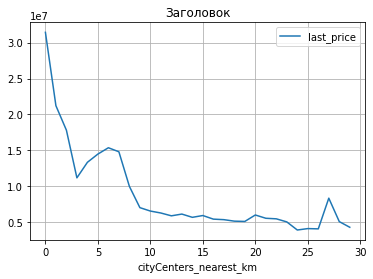

In [81]:
price_km.plot(grid = True, title = 'Заголовок');
pass

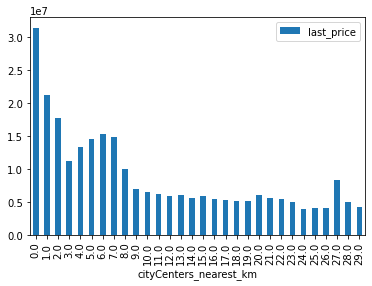

In [80]:
price_km.plot(kind='bar')
pass

Диаграммы показывают увеличение стоимости квартир с уменьшением расстояния до центра города. В 0 км очень дорогое жилье, на расстоянии 1 км стоимость уменьшается сразу на 10 млн. в 1,5 раза. Наблюдается провал в стоимости объектов на расстоянии 3 км (старые дома? неблагополучный район?) или наоборот это нормальные значения, а на расстоянии 5-7 км находится пик, завышаюший обычную цену (новое элитное жилье?). Сильно возрастает стоимость с 9 по 7 км. И есть пик стоимости на расстоянии 27 км, возможно какие-то новые ЖК.

**Вывод:** Средняя стоимость квартиры увеличивается от края к центру города. В 29 км от центра средняя стоимость квартиры 4,2 млн, в центре 31,5 млн. С 29 км до 9 км цена увеличивается постепенно от 4 до 7 млн. Начиная с 8 км цена быстро растет. Самый большой скачек цены в самом центре города, с 1 по 0 км цена увеличивается на 10 млн.

### Общий вывод

Стоимость квартир в основном зависит от общей площади и удаленности от центра. Остальные параметры имеют второстепенное значение.  
В самом центре квартиры стоят очень дорого, последний км до центра увеличивает стоимость квартиры в 1,5 раза и стоит 10 млн. Между 9 и 7 км от центра стоимость увеличивается 2 раза, с 7 до 14 млн.  
От этажности стоимость квартир зависит слабо, есть некоторый дисконт за 1 этаж.  
Не типичных квартир высокоэтажных, большой площади, или многокомнатных мало.  
Новые объявления размещают в основном по рабочим дням.  
Самые лучшие месяцы для выбора квартиры февраль-апрель и ноябрь.  
В первые два дня размещения квартиры очень мало продаются. Лучшие варианты продаются за неделю. Если квартира продается дольше года, значит с ней что-то не так.